In [1]:
import pandas as pd
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np 
import sklearn as sk
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import itertools
import warnings
import scipy.signal as sp
import math
from statsmodels.tsa.stattools import acf, pacf
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import datetime
import statistics
from sklearn import linear_model

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def convert_datetime(dTot):
    
    dTot['Date_Hour'] = pd.to_datetime(dTot.Date) + pd.to_timedelta(dTot.Hour, unit='h')
    
    
    
    dTot = dTot.drop(['Date','Hour'],axis = 1)
    dTot = dTot.set_index('Date_Hour')
    
    return dTot

In [3]:
#importing zonal data from 2015-2017, only taking total consumption
demand2013 = pd.read_csv("ZonalDemands_2013.csv", usecols = [0,1,2])
demand2014 = pd.read_csv("ZonalDemands_2014.csv", usecols = [0,1,2])
demand2015 = pd.read_csv("ZonalDemands_2015.csv", usecols = [0,1,2])
demand2016 = pd.read_csv("ZonalDemands_2016.csv", usecols = [0,1,2])
demand2017 = pd.read_csv("ZonalDemands_2017.csv", usecols = [0,1,2])

#convert to pandas dateTime
demand2013 = convert_datetime(demand2013).resample('D').max()
demand2014 = convert_datetime(demand2014).resample('D').max()
demand2015 = convert_datetime(demand2015).resample('D').max()
demand2016 = convert_datetime(demand2016).resample('D').max() 

demand2017 = convert_datetime(demand2017).resample('D').max()

#Remove weekends
#demand2013 = demand2013[demand2013.index.dayofweek < 5]


In [4]:
#1 day ahead
forecast_length = 1
print(len(demand2017))

366


In [66]:
#build models and validate
def test_model (train, test, i):

    #convert by log
    dTot_train_log = np.log(train[i]) # change
   
    #seasonal differencing
    seasons = 12
    dTot_train_log_ewma = dTot_train_log - dTot_train_log.shift(seasons)
    
    #fit model
    mod = sm.tsa.statespace.SARIMAX(dTot_train_log_ewma.resample('D'),
                                    order=(1, 2, 1),
                                    seasonal_order=(0, 1, 1, seasons),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()

 
    #forecast
    forecast_log_diff = pd.Series(results.get_forecast(steps = forecast_length).predicted_mean, copy = True)
    forecast_log_diff.index  = test[i].index #.resample('D').mean()
    
    #Remove differencing 
    forecast_log =  forecast_log_diff + dTot_train_log.shift(seasons).iloc[len(train[i])-1] #try mean?
    
    #Remove log
    forecast =  pd.Series(np.exp(forecast_log), index=forecast_log.index)
    
    
    #print(forecast)
    #plt.plot(forecast)
    #print(forecast)
    #plt.plot(test[i])
    #print(test[i])
    #plt.legend(['Forecast','Test'])

    #AIC = results.aic
    #RMSE = (forecast - test[i].Total).abs()
    #RMSE = math.sqrt((((forecast - test[i].Total)**2).mean())) 

    #print('AIC:')
    #print(AIC)
    #print('RMSE:')
    #print(RMSE)

    #plt.plot(dTot_train_log_ewma)
    #Plot auto and partial correlation
    #fig = plt.figure(figsize=(12,8))
    #ax1 = fig.add_subplot()
    #fig = sm.graphics.tsa.plot_acf(dTot_train_log_ewma, lags=40, ax=ax1)
    #ax2 = fig.add_subplot()
    #fig = sm.graphics.tsa.plot_pacf(dTot_train_log_ewma, lags=40, ax=ax2)

    return forecast


In [67]:
#Spilt into train/test
train = []
test = []
results = []

start = 2 #if 1 delete append 2017 in train, remember to change for loop length i.e 260 if 1

ctr = start+forecast_length #forecast_length

train.append(pd.concat([demand2016,demand2017.iloc[0:start]])) #,demand2017.iloc[0:130] summer only
test.append(demand2017.iloc[start]) #[0:forecast_length]
results.append(test_model(train,test,0))

#int(round(260/forecast_length))

for i in range(1,365): #(1,260) summer only
    
    train.append(train[i-1].append(test[i-1]))
    test.append(demand2017.iloc[ctr])
    ctr = ctr + forecast_length
    results.append(test_model(train,test,i))
   
    

#print(results)
#print(np.mean(results))
#print(np.std(results))
#plt.hist(results)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:544: FutureWarning: 
.resample() is now a deferred operation
You called __array__(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  return array(a, dtype, copy=False, order=order, subok=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

IndexError: single positional indexer is out-of-bounds

1084.4351921159007
831.5811413628464


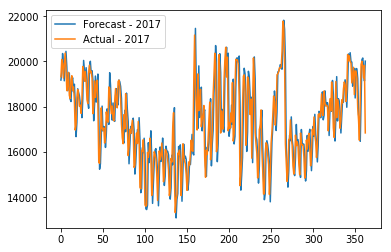

In [68]:
error = []

for i in range(0,364):
    
    error.append((test[i] - results[i]).abs())
    

r1 = 1
r2 = 364
plt.plot(results[r1:r2])
plt.plot(test[r1:r2])
plt.legend(['Forecast - 2017','Actual - 2017'])

from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test[r1:r2], results[r1:r2]))
print(rms)
print(np.mean(error[r1:r2]))


In [69]:
#max analysis
days = 5
resultsdf = pd.DataFrame(results)
testdf = pd.DataFrame(test)
testdf['new_index'] = range(0,364)
testdf.index = testdf['new_index']
testdf = testdf.drop(['new_index'],axis = 1)

print(testdf.nlargest(days,'Total'))

print(resultsdf.iloc[testdf.nlargest(days,'Total').index.tolist()])

print((testdf.nlargest(days,'Total') - resultsdf.iloc[testdf.nlargest(5,'Total').index.tolist()]))

print((testdf.nlargest(days,'Total') - resultsdf.iloc[testdf.nlargest(5,'Total').index.tolist()]).mean())


           Total
new_index       
265        21786
266        21542
160        21168
197        20627
264        20457
            Total
265  20510.718786
266  21824.158456
160  19430.249810
197  20066.720164
264  19658.034981
                 Total
new_index             
265        1275.281214
266        -282.158456
160        1737.750190
197         560.279836
264         798.965019
Total    818.023561
dtype: float64


In [ ]:
#find SARIMAX with optimal hyperparameters

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dTot_train_log_ewma,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-1824.0954844715936
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:-1790.179947552922
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-1726.3471784421533
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:-1703.9427906136634
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:-1115.129819714417
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-1822.3404690031432
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-1822.5562158387256
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:-1792.6634300618641
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-1387.3474290601107
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-1733.5031954195051
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:-1701.9678310914665
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:-730.7049383648155
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:-1299.5806631792393
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:-1564.7120533351426
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:-1804.1589782237302
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:-1806.2677710694027
ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:-1878.1226166706463
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - A

In [29]:
mod = sm.tsa.statespace.SARIMAX(dTot_train_log_ewma,
                                order=(2, 2, 0),
                                seasonal_order=(0, 3, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Total   No. Observations:                  738
Model:             SARIMAX(2, 2, 0)x(0, 3, 0, 12)   Log Likelihood                  -0.134
Date:                            Tue, 20 Mar 2018   AIC                              6.268
Time:                                    16:36:17   BIC                             20.080
Sample:                                01-01-2015   HQIC                            11.594
                                     - 01-06-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4110      0.026    -15.832      0.000      -0.462      -0.360
ar.L2         -0.6734      0.029   

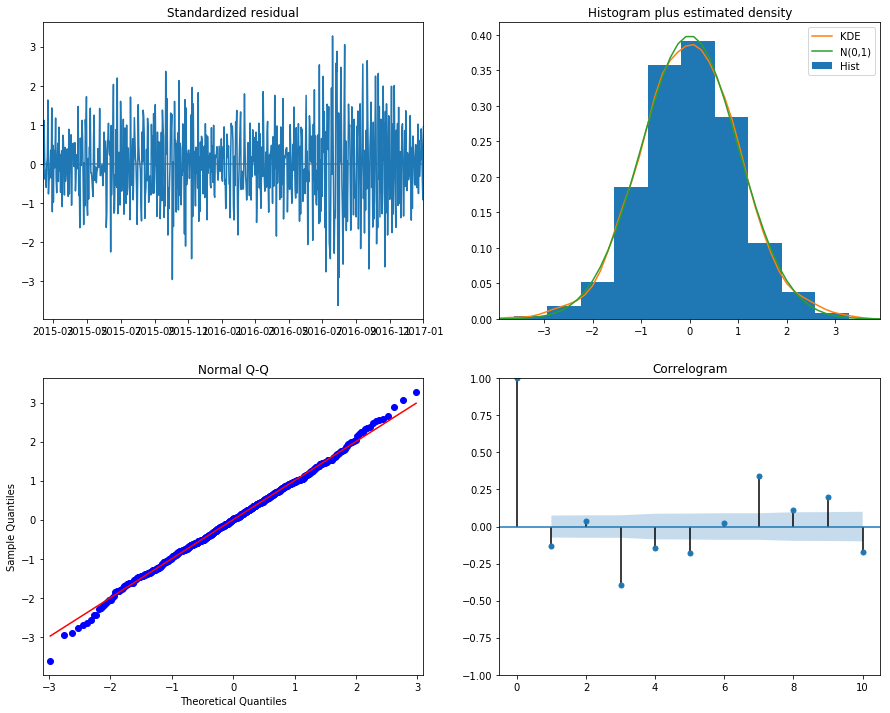

In [88]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()